In [1]:
import warnings; warnings.simplefilter('ignore')

In [24]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pystan
from datetime import datetime, timedelta

from time import sleep
import os
from IPython.display import display

%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

from functions.helper_functions import (StanModel_cache, 
                                        vb, model_dict, 
                                        minimal_variance_portfolio,
                                        get_rebalancing_times)

run_in_parallel = False

<h3>Run the following cell, if you want to run different models in parallel, otherwise skip the cell.</h3>
<p>Before running the cell, start clusters. E.g. run 'ipcluster start -n 4'.</p>
<p>More information on: https://ipyparallel.readthedocs.io/en/latest/intro.html#getting-started </p>

In [4]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc.load_balanced_view()

with rc[:].sync_imports():
    import numpy as np
    import pandas as pd
    import pystan
    
    from functions.helper_functions import (vb, model_dict, minimal_variance_portfolio)
print(rc.ids)

run_in_parallel = True

importing numpy on engine(s)
importing pandas on engine(s)
importing pystan on engine(s)
importing vb,model_dict,minimal_variance_portfolio from functions.helper_functions on engine(s)
[0, 1, 2, 3]


<h1>Load Data</h1>

start: 2018-01-30 00:00:00	 end: 2020-12-24 00:00:00
number of nan's: 0
shape data: (1060, 19)


,XLM-USD,BCH-USD,ADA-USD,LTC-USD,BTC-USD,XRP-USD,MANA-USD,BAT-USD,USDT-USD,ETH-USD,FIL-USD,BNT-USD,BNB-USD,ZEC-USD,XMR-USD,DOGE-USD,DASH-USD,MIOTA-USD,THETA-USD
Date,,,,,,,,,,,,,,,,,,,
2018-01-30,-0.169078,-0.112598,-0.146487,-0.090210,-0.105352,-0.140041,-0.157442,-0.161097,-0.008875,-0.094075,-0.014966,-0.116169,-0.118595,-0.145205,-0.134581,-0.135352,-0.118246,-0.138811,-0.231703
2018-01-31,0.102418,0.011111,-0.023684,-0.011647,0.011359,0.020930,0.126620,0.015149,0.003840,0.044047,0.015528,0.033437,-0.009395,0.037572,-0.004113,-0.002324,0.030357,0.040288,0.006393
2018-02-01,-0.154395,-0.142943,-0.188023,-0.128888,-0.102783,-0.171939,-0.202484,-0.106391,-0.003368,-0.072896,-0.047941,-0.070738,-0.146179,0.007191,-0.116985,-0.163228,-0.115301,-0.173867,-0.116124
2018-02-02,-0.112563,-0.065296,-0.073844,-0.076727,-0.037052,-0.080773,-0.065286,-0.099226,0.003858,-0.116711,0.053420,-0.096357,0.014339,-0.042903,-0.022140,-0.110161,-0.048880,-0.051861,-0.107118
2018-02-03,0.061670,0.068304,0.123682,0.219754,0.038973,0.044371,0.113576,0.077764,0.010662,0.052670,-0.050898,0.044118,0.010090,0.013026,0.067725,0.153966,0.086035,0.100368,0.094530


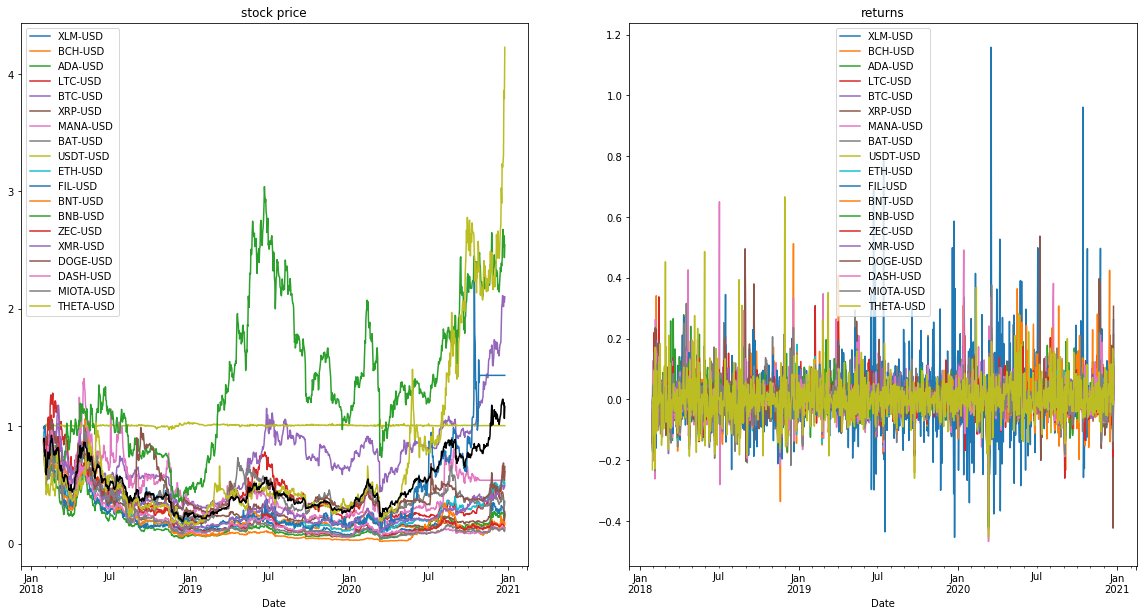

In [5]:
N = 30# max: 120

data = pd.read_csv('crypto_portfolio.csv', index_col='Date', parse_dates=['Date'])
data = data.drop(columns=['CL=F', 'AAPL','^GDAXI','TSLA','^IXIC','TRX-USD'])
data = data.iloc[0:1060]
stock_list = data.columns
start = data.index[0]
end = data.index[-1]

print("start: {}\t end: {}".format(start, end))
print( "number of nan's: {}".format(data.isna().sum().sum()) )
print( "shape data: {}".format(data.shape) )
display(data.head())



# visualize data
if N <= 80:
    pltdata=data.iloc
    fig = plt.figure(figsize=(20,10))

    ax = fig.add_subplot(121)
    np.cumprod(1+data, axis=0).plot(ax=ax, title='stock price')
    np.cumprod(1+data.mean(axis=1)).plot(ax=ax, label='mean', color='black')

    ax = fig.add_subplot(122)
    data.plot(ax=ax, title='returns')

    plt.show()

<h1>Compile Stan Code</h1>

In [13]:
file = "functions/stan_gplvm_finance.stan"
with open(file) as f:
    stan_code = f.read()

stan_model = StanModel_cache(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_360dd93f7d9bda65d2052b75dc4f04d2 NOW.


<h1>Train Model</h1>

In [7]:
def run_calc(model_name, Q, now, num):
    #shared variables: N, D, data, model_dict, stan_model, tries, window, delta
    import pandas as pd
    import numpy as np
    from sklearn.covariance import LedoitWolf
    
    Y_train = data.loc[now-window:now, :].copy().values.T
    D_train = Y_train.shape[1]
    
    if model_name == 'sample_cov':
        cov = 1./Y_train.shape[1]*Y_train.dot(Y_train.T)
        elbo, r2, lengthscale = np.nan, np.nan, np.nan
    elif model_name == 'ledoit_wolf':
        lw = LedoitWolf(store_precision=False, assume_centered=True)
        lw = lw.fit(Y_train.T)
        cov = lw.covariance_
        elbo, r2, lengthscale = np.nan, np.nan, np.nan
    else:
        data_dict = {'N':N, 'D':D_train, 'Q':Q, 'Y':Y_train, 'model_number':model_dict[model_name]}
        n_error, should_break, n_error_max = 0, False, 5
        while n_error<n_error_max:    # sometimes, bad initialization leads to RuntimeError, 
                                      # if more then 5 times: break.
            try:
                diagnostic, sample = vb(data_dict, stan_model, tries=tries, num=num)
                n_error = n_error_max
            except RuntimeError:
                n_error += 1
                if n_error == n_error_max: should_break = True
                print('RuntimeError')

        if should_break:
            print('RuntimeError occurred too often.')
            return None

        elbo = diagnostic.loc[:, 'ELBO'].values[-1]
        r2 = sample.filter(regex='^R2_hat_N$').mean(axis=0).values.squeeze()
        lengthscale = sample.filter(regex='^kernel_lengthscale$')\
            .mean(axis=0).values.squeeze()
        
        cov = sample.filter(regex='^K').mean(axis=0).values.reshape(N,-1)
    
    
    #idx_names = ['model_name', 'Q', 'now', 'num']
    #idx = (model_name, Q, now, num)
    idx_names = ['num']
    idx = (num)

    #col_names = ['ELBO', 'R2', 'inv_lengthscale']
    #df = pd.DataFrame({idx: (elbo, r2, inv_lengthscale)}, index=col_names).T
    col_names = ['model_name', 'Q', 'ELBO', 'R2', 'lengthscale', 'now']
    df = pd.DataFrame({idx: (model_name, Q, elbo, r2, lengthscale, now)}, index=col_names).T
    df.index.set_names(idx_names, inplace=True)
    
    
    weights = minimal_variance_portfolio(Y_train, cov)
    df_w = pd.DataFrame({idx:weights}, index=['w{}'.format(i) for i in range(N)]).T
    df_w.index.set_names(idx_names, inplace=True)
    
    #col_names = ['model_name', 'Q', 'ELBO', 'R2', 'inv_lengthscale']
    #df = pd.DataFrame({num: (model_name, Q, elbo, r2, inv_lengthscale)}, index=col_names).T
    
    return pd.concat((df, df_w), axis=1)

<h2>Specify parameter</h2>
<p>to get a better convergence, increase 'tries'. Note that $Y \in \mathbb{R}^{N \times D}$ is data.T</p>

In [18]:
Y = data.T.values    # NxD input matrix to GPLVM 
N, D = Y.shape 
window = timedelta(50)   # learning period
delta = timedelta(10)    # predicting period
tries = 10            # number of runs for each Q and kernel. 
                     # run with the highest ELBO is kept

print(Y.shape)

#'linear', 'squared_exp', 'squared_exp_m_linear',
    
model_names = ['matern32', 'squared_exp_p_linear', 'sample_cov', 'ledoit_wolf']
Qs = [3]

## possible models: 'linear', 'squared_exp', 'exp', 'matern32', 'matern52', 
##                'squared_exp_m_linear', 'exp_m_linear', 'squared_exp_p_linear', 'exp_p_linear'

start, end = start, end
rebalancing_times = get_rebalancing_times(start, end, window, delta)

inp = [(model_name, Q, t) for model_name in model_names for Q in Qs for t in rebalancing_times]

# randint used to name temporary files, avoids conflicts between different runs
randint = np.random.randint(0, 1e+5)       
inp = [[*el, i+randint] for i, el in enumerate(inp)]
print('number inputs: {}'.format(len(inp)))


(19, 1060)
number inputs: 400


<hr>
<h4>If ipyparallel is imported the runs are distributed among all CPUs
otherwise inp-list is processed sequentially</h4>
<p>Note: if the list of inputs is too long and you not running ipyparallel, it might take a lot of time</p>

In [19]:
%%time
if run_in_parallel:
    async_res = []
    ids = []

    rc[:].push(dict(N=N, D=D, data=data, model_dict=model_dict, 
                    stan_model=stan_model, tries=tries,
                    window=window, delta=delta), block=True)

    for param in inp:
        re = dview.apply_async(run_calc, *param)
        async_res.append(re)
        ids.extend(re.msg_ids)

        
    # display progress
    sleep(10)
    while True:
        print(str(len(rc.result_status(ids)['pending'])) +"/"
              +str(len(rc.result_status(ids)['pending'])
                   +len(rc.result_status(ids)['completed']))
              +" still running. on " + str(len(rc.ids)) + " cores", end="\r")
        sleep(10)
        if len(rc.result_status(ids)['pending']) == 0: break
    
    
    # collect results 
    results = [r.get() for r in async_res]
    
    
else:
    # to get rid of the stan-warnings comment out the warning lines (second and 
    # third last line) in the pystan source code (file: pystan/model.py - vb() )
    # if you use a pickled model - recompile it after commenting out the lines
    
    results = []
    print('starting calculations ...', flush=True)
    for i, inp_ in enumerate(inp):
        results.append( run_calc(*inp_) )
        print('{}% done'.format( int(100*(i+1)/len(inp)) ), end='\r', flush=True)


if len(results[0]) == 1:  # only if run_calc() just returns a dataframe (no cov or X)
    results = pd.concat(results)

CPU times: user 3.52 s, sys: 295 ms, total: 3.82 s
Wall time: 21min 24s


<h4>Display Results</h4>

,"(matern32, 3)","(squared_exp_p_linear, 3)","(sample_cov, 3)","(ledoit_wolf, 3)",eq_weight
mean,0.343423,0.400980,0.389253,0.376932,0.363314
std,0.565973,0.566881,0.561569,0.559944,0.628902
sharpe ratio,0.606784,0.707345,0.693153,0.673161,0.577696


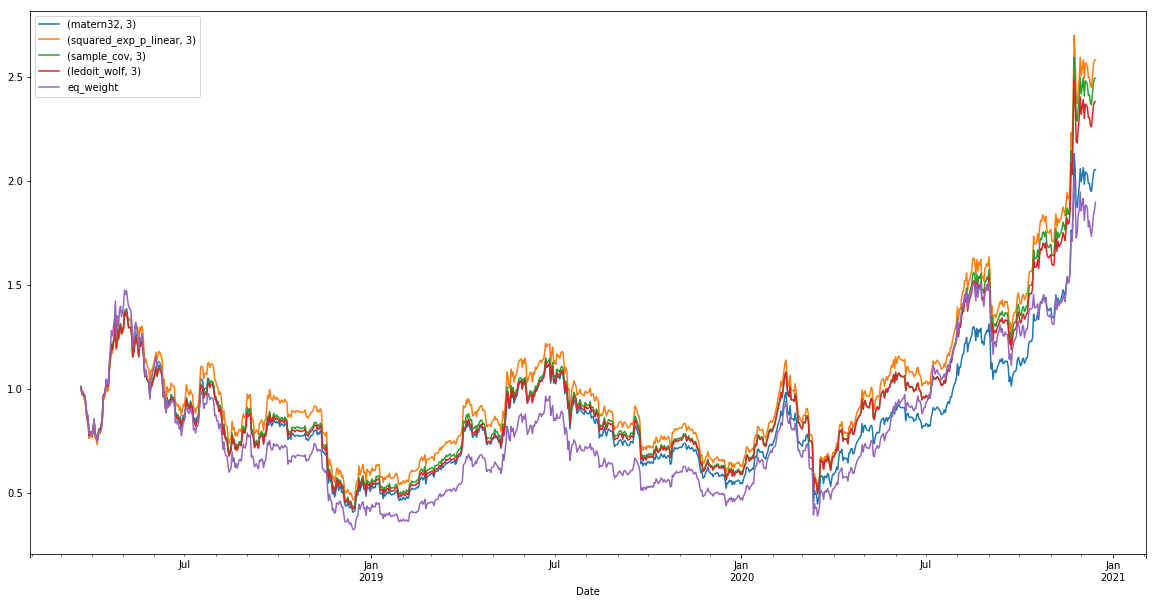

In [20]:
idx = [(model_name, Q) for model_name in model_names for Q in Qs] + ['eq_weight',]
df_performance = pd.DataFrame(index=idx, columns=data.index)


for now, df_g in results.groupby(by='now'):
    idx =  [(i,j) for i,j in df_g.loc[:,['model_name', 'Q']].values]
    ret = np.matmul(df_g.filter(regex='^w'), data.loc[now:now+delta, :].T)
    df_performance.loc[idx, now:now+delta] = ret
    df_performance.loc['eq_weight', now:now+delta] = np.matmul(1./N*np.ones(shape=(1, N)),
                                                          data.loc[now:now+delta, :].T)

df_performance.dropna(axis=1, inplace=True)

mean = lambda x: x.mean()*250
std = lambda x: x.std()*np.sqrt(250)
sharpe_ratio = lambda x: mean(x)/std(x)

df_performance_eval = df_performance.T.apply([mean, std, sharpe_ratio])
df_performance_eval.index = ['mean', 'std', 'sharpe ratio']
display(df_performance_eval)

np.cumprod(1+df_performance.T).plot(figsize=(20,10));

In [1]:
results['model_name'=='matern32']

NameError: name 'results' is not defined